# 4-1 差异表达分析

## 1. 背景

我们在前面注释的章节中，研究了不同细胞的特异性marker（标记）基因，但很多时候，我们更关心在某一类细胞中，两种不同状态下的组别差异，例如药物治疗与未经药物治疗，肿瘤细胞与正常细胞（癌旁）细胞等。因此，我们希望能在单细胞水平上，进行差异表达分析。

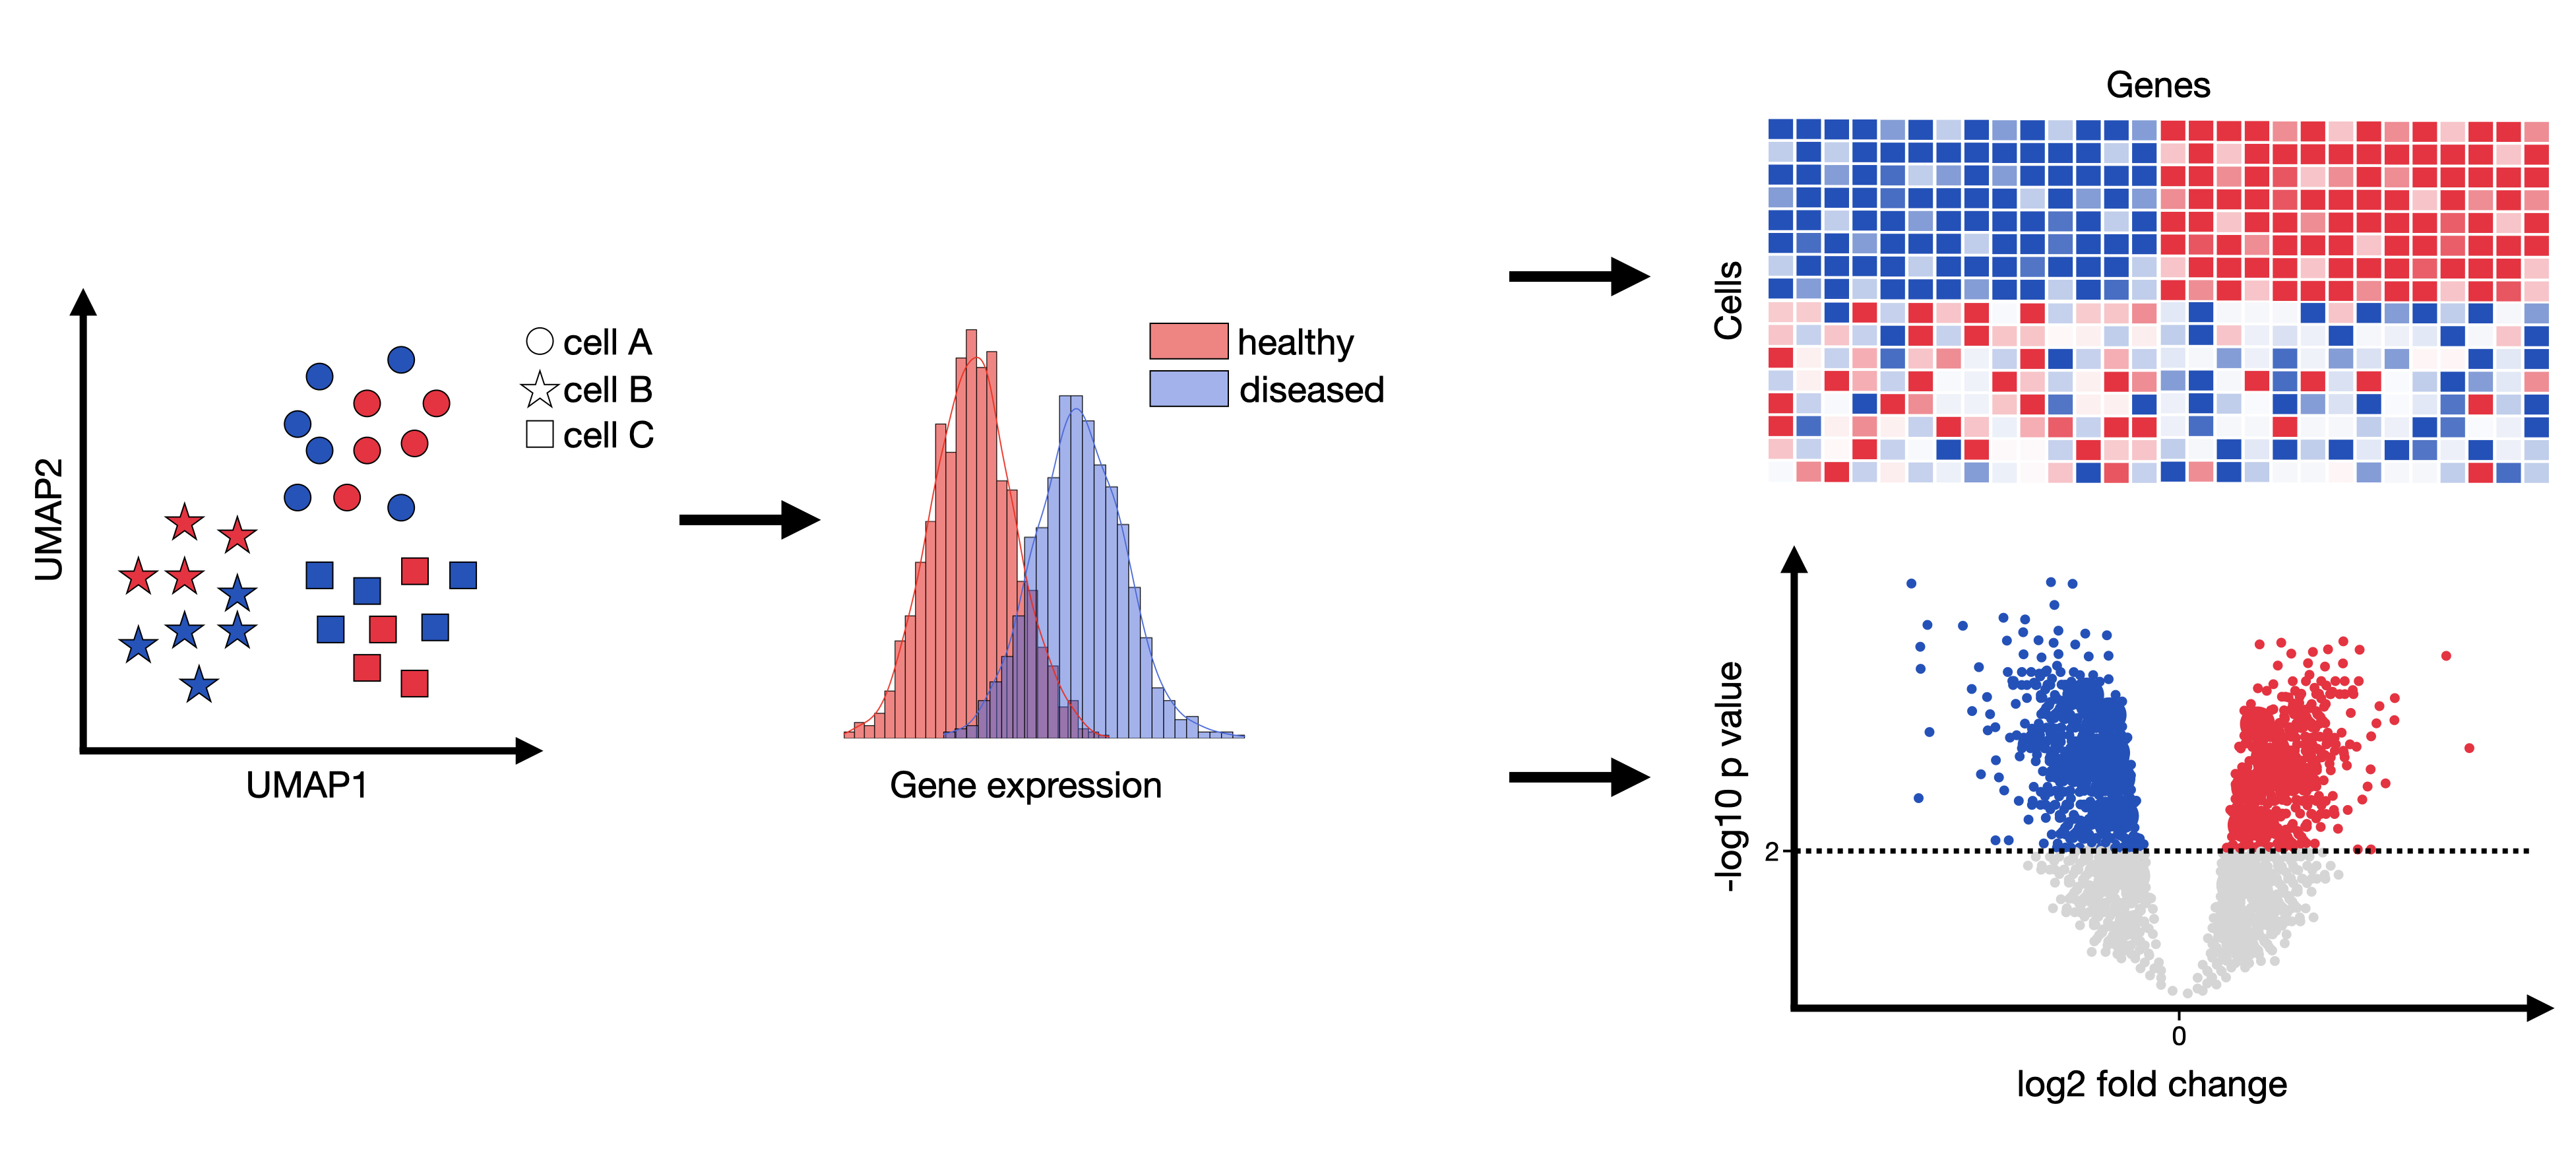

单细胞RNA-seq与批量RNA-seq数据相比，有着更强的稀疏性，例如dropout现象的普遍出现，这使得我们如果仅仅将每一个细胞视作样本进行差异表达分析，由于显著性检验的P值对于样本量的敏感度很高，因此如果使用全部细胞进行差异表达分析，那么分析结果中的显著性差异可能是不可靠的。我们在下面的对比实验会进一步说明这种现象。为了解决单细胞稀疏性与样本过大的问题，我们可以采用一种叫做伪Bulk（pseudo-bulk）的方法来聚合单细胞数据，从而进行差异表达分析。但这又引入另一个问题，最近的一项研究强调了伪Bulk的问题，其中推论统计应用于统计上不独立的生物复制。未能考虑重复（来自同一个体的细胞）的内在相关性会增加错误发现率（FDR）[ Junttila等人。，2022，斯奎尔等人。，2021，齐默尔曼等人。，2021 ]。因此，应在差异表达分析之前，应先应用批量效应校正或通过每个个体的总和、平均或随机效应（即伪Bulk生成）对个体内的细胞类型特异性表达值进行聚合，以解释样本内相关性。

元细胞的概念（代表不同细胞状态的细胞组，其中元细胞内的变异是由于技术而非生物来源）被提出作为保持统计效用同时最大化有效数据分辨率的一种方式。与伪Bulk不同，SEACells 寻求以与数据模态无关的方式将单个细胞聚合成代表不同细胞状态的元细胞。使用计数矩阵作为输入，它提供每个元单元的每个单元权重、每个元单元的每个单元硬分配以及每个元单元的聚合计数作为输出，故在本教程中，我们将展示如何使用SEACells完成差异表达分析。

In [1]:
import omicverse as ov
import scanpy as sc
import scvelo as scv

ov.utils.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.5, Tutorials: https://omicverse.readthedocs.io/


## 2. 加载数据

在这里，我们使用pertpy的演示数据Kang 数据集，它是来自 8 名狼疮患者 INF-β 治疗前后 6 小时前后的 10 倍基于 scRNA-seq 的外周血单核细胞 (PBMC) 数据（总共 16 个样本）

下载地址：https://figshare.com/ndownloader/files/34464122

In [3]:
adata = ov.read('data/kang.h5ad')
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [4]:
adata.X.max()

3828.0

与别的方法不一样，我们在这里使用ttest方法计算差异表达基因，因此我们需要使用log对数化处理后的数据，因此我们对数据进行预处理

In [5]:
#quantity control
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250})
#normalize and high variable genes (HVGs) calculated
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)

#save the whole genes and filter the non-HVGs
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]

#scale the adata.X
ov.pp.scale(adata)

#Dimensionality Reduction
ov.pp.pca(adata,layer='scaled',n_pcs=50)

adata.obsm['X_mde']=ov.utils.mde(adata.obsm['scaled|original|X_pca'])

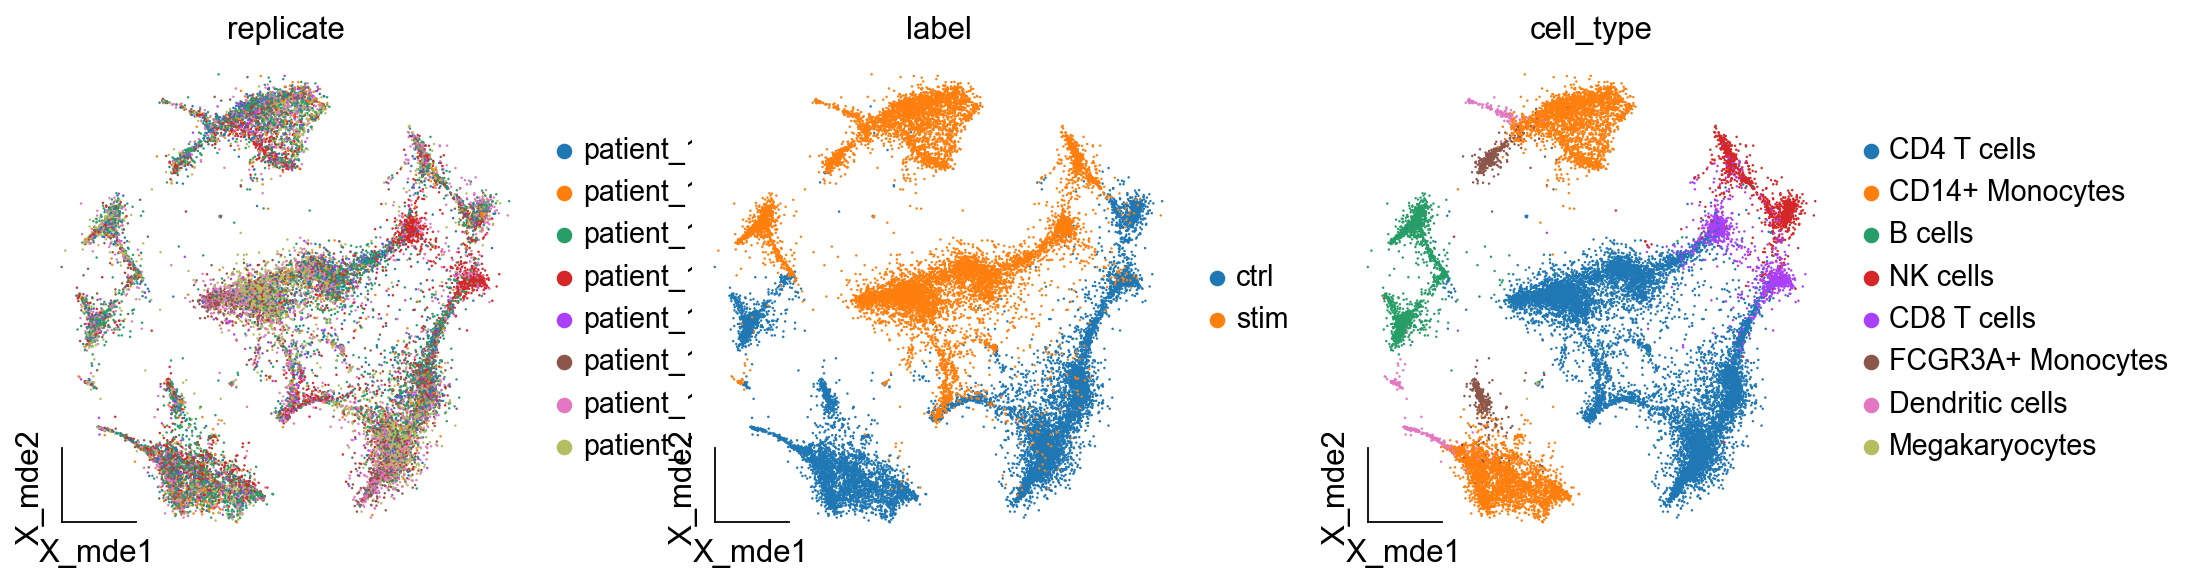

In [12]:
ov.utils.embedding(adata,
                   basis='X_mde',
                    frameon='small',
                   color=['replicate','label','cell_type'])

## 3. 批次效应的校正

我们发现数据存在着一定的批次效应，我们这里使用scVU进行批次效应的校正。当然，你也可以使用别的方法，如harmony等，更多的批次效应校正的方法见omicverse的教程：https://omicverse.readthedocs.io/en/latest/Tutorials-single/t_single_batch/

In [17]:
adata=ov.single.batch_correction(adata,batch_key='replicate',
                           methods='scVI',n_layers=2, n_latent=30, gene_likelihood="nb")
adata.obsm["X_mde_scVI"] = ov.utils.mde(adata.obsm["X_scVI"])

...Begin using scVI to correct batch effect


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 326/326: 100%|██████████| 326/326 [13:22<00:00,  2.47s/it, loss=599, v_num=1]

`Trainer.fit` stopped: `max_epochs=326` reached.


Epoch 326/326: 100%|██████████| 326/326 [13:22<00:00,  2.46s/it, loss=599, v_num=1]


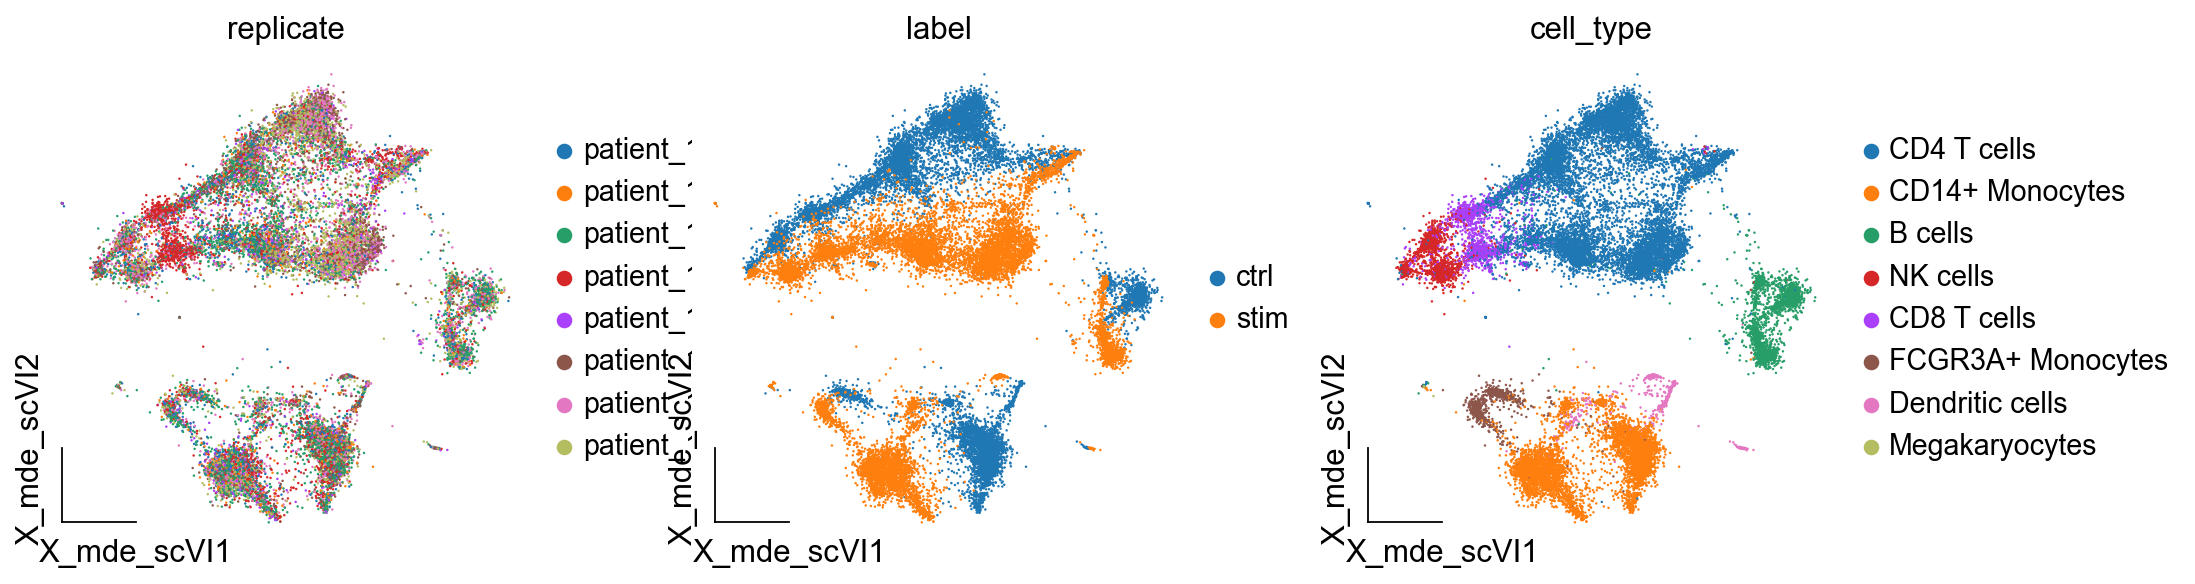

In [18]:
ov.utils.embedding(adata,
                   basis='X_mde_scVI',
                    frameon='small',
                   color=['replicate','label','cell_type'])

## 4. 差异表达分析（全细胞水平）

在使用元细胞分析前，我想先使用全细胞水平进行分析，以展示全细胞水平下的差异表达分析效果，在教程中，我们只分析CD4 T cells的差异表达基因，希望能通过CD4 T cells的差异来表明治疗前后免疫应答响应的变化。

我们这里可以使用ttest或者是DESeq2两种模型，两种模型的效果我将分别演示：

### 4.1 基于ttest进行差异表达分析

对于ttest统计方法而言，数据要求满足正态分布的基本形式。中心极限定理，是指概率论中讨论随机变量和分布渐近于正态分布的定理，是数理统计学和误差分析的理论基础，指出了大量随机变量近似服从正态分布的条件。故我们使用原数据的对数标准化后的内容，来进行差异表达分析。

In [19]:
test_adata=adata[adata.obs['cell_type'].isin(['CD4 T cells'])]
dds=ov.bulk.pyDEG(test_adata.to_df(layer='lognorm').T)
dds.drop_duplicates_index()
print('... drop_duplicates_index success')

... drop_duplicates_index success


我们选取label分别为`Ctrl`与`Stim`作为需要进行差异分析的两个组别

In [22]:
treatment_groups=test_adata.obs[test_adata.obs['label']=='stim'].index.tolist()
control_groups=test_adata.obs[test_adata.obs['label']=='ctrl'].index.tolist()
dds.deg_analysis(treatment_groups,control_groups,method='ttest')

pvalue        qvalue  FoldChange  -log(pvalue)  -log(qvalue)  \
index                                                                          
HES4      6.990619e-16  6.657732e-15    3.064049     15.155484     14.176674   
ISG15     0.000000e+00  0.000000e+00    7.811245           inf           inf   
TNFRSF18  4.381517e-02  1.067851e-01    0.816003      1.358375      0.971489   
TNFRSF4   9.381502e-02  1.977134e-01    1.129927      1.027728      0.703964   
MIB2      4.989855e-04  1.980101e-03    0.652638      3.301912      2.703313   
...                ...           ...         ...           ...           ...   
CSTB      2.075914e-04  8.833677e-04    0.864409      3.682791      3.053858   
ADARB1    1.221471e-01  2.425960e-01    0.674020      0.913117      0.615116   
COL6A2    4.130318e-01  5.700922e-01    0.666100      0.384017      0.244055   
SPATC1L   4.442675e-03  1.430813e-02    0.533702      2.352355      1.844417   
S100B     7.742601e-03  2.371394e-02    0.652563      2.111113      1.624996   

          BaseMean  log2(BaseMean)    log2FC  abs(log2FC)      size     sig  
index                                                                        
HES4      0.137813       -2.859214  1.615440     1.615440  0.306405     sig  
ISG15     4.349746        2.120931  2.965553     2.965553  0.781125     sig  
TNFRSF18  0.212021       -2.237723 -0.293354     0.293354  0.081600  normal  
TNFRSF4   0.400718       -1.319340  0.176229     0.176229  0.112993  normal  
MIB2      0.146249       -2.773502 -0.615645     0.615645  0.065264     sig  
...            ...             ...       ...          ...       ...     ...  
CSTB      1.171551        0.228420 -0.210215     0.210215  0.086441     sig  
ADARB1    0.033824       -4.885810 -0.569136     0.569136  0.067402  normal  
COL6A2    0.008253       -6.920919 -0.586190     0.586190  0.066610  normal  
SPATC1L   0.046102       -4.439028 -0.905894     0.905894  0.053370     sig  
S100B     0.087292       -3.518006 -0.615811     0.615811  0.065256     sig  

[1973 rows x 11 columns]

并且我们不指定差异表达倍数，由算法根据数据的分布自动计算合适的阈值

In [23]:
# -1 means automatically calculates
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=10)

... Fold change threshold: 0.8351151943206787


我们使用自带的火山图函数`plot_volcano`来观察差异表达基因的分布

(<Figure size 320x320 with 1 Axes>,
 <AxesSubplot: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>)

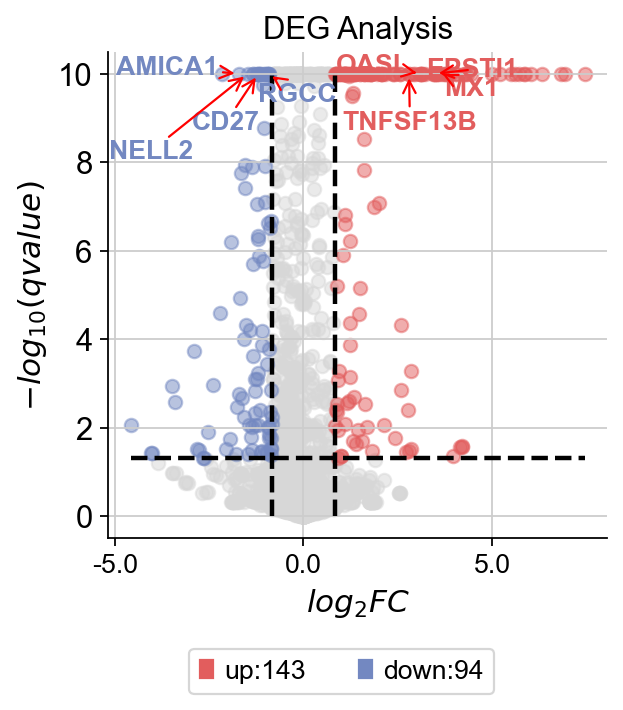

In [24]:
dds.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

我们还可以使用自带的箱线图函数`plot_boxplot`来观察差异表达基因在不同组的差异情况

(<Figure size 160x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

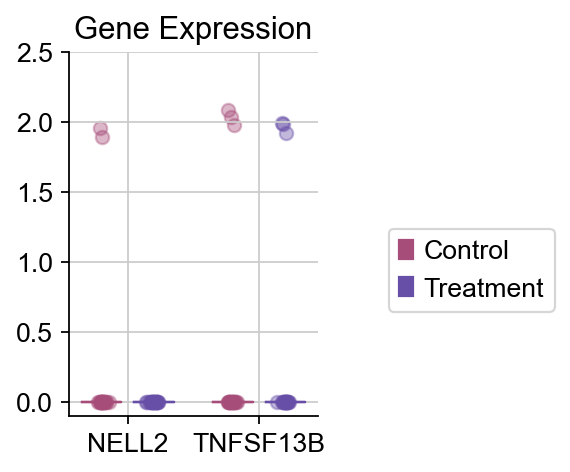

In [29]:
dds.plot_boxplot(genes=['NELL2','TNFSF13B'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))

除此之外，我们还可以在低维流型图umap中，观察差异表达基因在不同组的分布情况

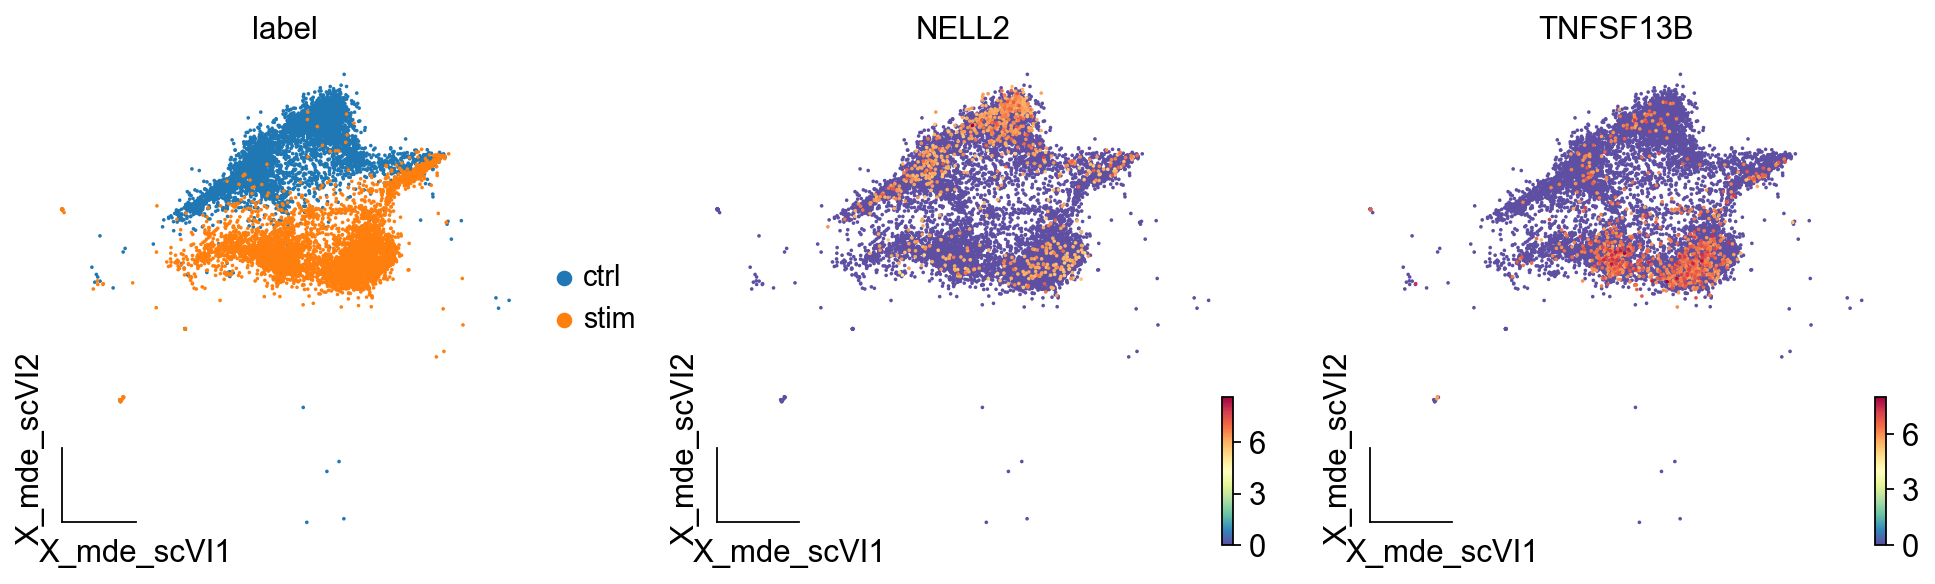

In [30]:
ov.utils.embedding(test_adata,
                   basis='X_mde_scVI',
                    frameon='small',
                   color=['label','NELL2','TNFSF13B'])

### 4.2 基于DEseq2进行差异表达分析

DEseq2被广泛使用在差异表达分析的各种场合，得益于其负二项分布模型的设计。使得我们可以使用原始计数Counts进行直接分析。DESeq2将对原始reads进行建模，使用标准化因子(scale factor)来解释库深度的差异。然后，DESeq2估计基因的离散度，并缩小这些估计值以生成更准确的离散度估计，从而对reads count进行建模。最后，DESeq2拟合负二项分布的模型，并使用Wald检验或似然比检验进行假设检验。

与ttest不同，使用DEseq2时不用考虑数据与正态分布之间的关系，也不用考虑数据特征。

In [73]:
test_adata=adata[adata.obs['cell_type'].isin(['CD4 T cells'])]
dds=ov.bulk.pyDEG(test_adata.to_df(layer='counts').T)
dds.drop_duplicates_index()
print('... drop_duplicates_index success')

treatment_groups=test_adata.obs[test_adata.obs['label']=='stim'].index.tolist()
control_groups=test_adata.obs[test_adata.obs['label']=='ctrl'].index.tolist()
dds.deg_analysis(treatment_groups,control_groups,method='DEseq2')

... drop_duplicates_index success
Fitting size factors...
... done in 0.20 seconds.

Fitting dispersions...
... done in 3.69 seconds.

Fitting dispersion trend curve...
... done in 0.60 seconds.

logres_prior=nan, sigma_prior=nan
Fitting MAP dispersions...
... done in 73.18 seconds.

Fitting LFCs...
... done in 299.53 seconds.

Refitting 5 outliers.

Fitting dispersions...
... done in 0.09 seconds.

Fitting MAP dispersions...
... done in 0.23 seconds.

Fitting LFCs...
... done in 0.70 seconds.

Running Wald tests...
... done in 71.47 seconds.

Log2 fold change & Wald test p-value: condition Treatment vs Control


baseMean  log2FoldChange     lfcSE       stat        pvalue  \
index                                                                   
HES4      0.030476       -0.604007  0.345610  -1.747656  8.052364e-02   
ISG15     3.216346        3.922108  0.039929  98.227317  0.000000e+00   
TNFRSF18  0.040795       -0.712627  0.258011  -2.762004  5.744771e-03   
TNFRSF4   0.083583       -0.639698  0.166562  -3.840593  1.227376e-04   
MIB2      0.028371       -0.722285  0.330413  -2.186008  2.881499e-02   
...            ...             ...       ...        ...           ...   
CSTB      0.220609       -0.783097  0.067958 -11.523315  1.006621e-30   
ADARB1    0.006937       -0.693888  0.852002  -0.814421  4.154035e-01   
COL6A2    0.001386       -0.688974  2.029533  -0.339474  7.342525e-01   
SPATC1L   0.008585       -0.700738  0.693033  -1.011119  3.119595e-01   
S100B     0.019704       -0.719129  0.468072  -1.536362  1.244495e-01   

                  padj  
index                   
HES4      9.163035e-02  
ISG15     0.000000e+00  
TNFRSF18  8.895129e-03  
TNFRSF4   2.473491e-04  
MIB2      3.827501e-02  
...                ...  
CSTB      4.703504e-30  
ADARB1             NaN  
COL6A2             NaN  
SPATC1L            NaN  
S100B     1.334200e-01  

[2000 rows x 6 columns]

... Fold change threshold: 0.7119915291998109


In [76]:
# -1 means automatically calculates
dds.foldchange_set(fc_threshold=1.2,
                   pval_threshold=0.05,
                   logp_max=10)

... Fold change threshold: 1.2


(<Figure size 320x320 with 1 Axes>,
 <AxesSubplot: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>)

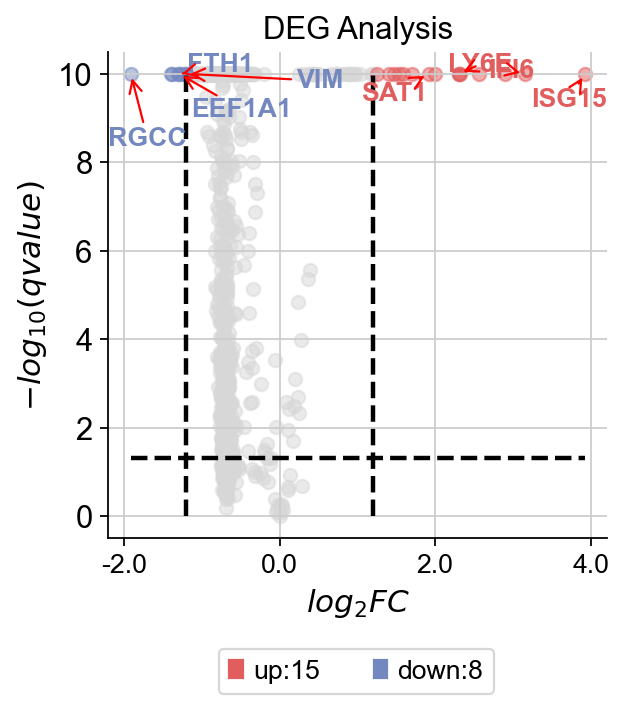

In [77]:
dds.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

(<Figure size 160x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

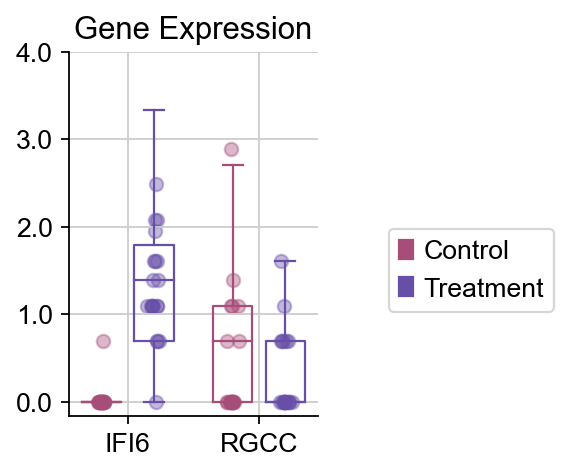

In [80]:
dds.plot_boxplot(genes=['IFI6','RGCC'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))

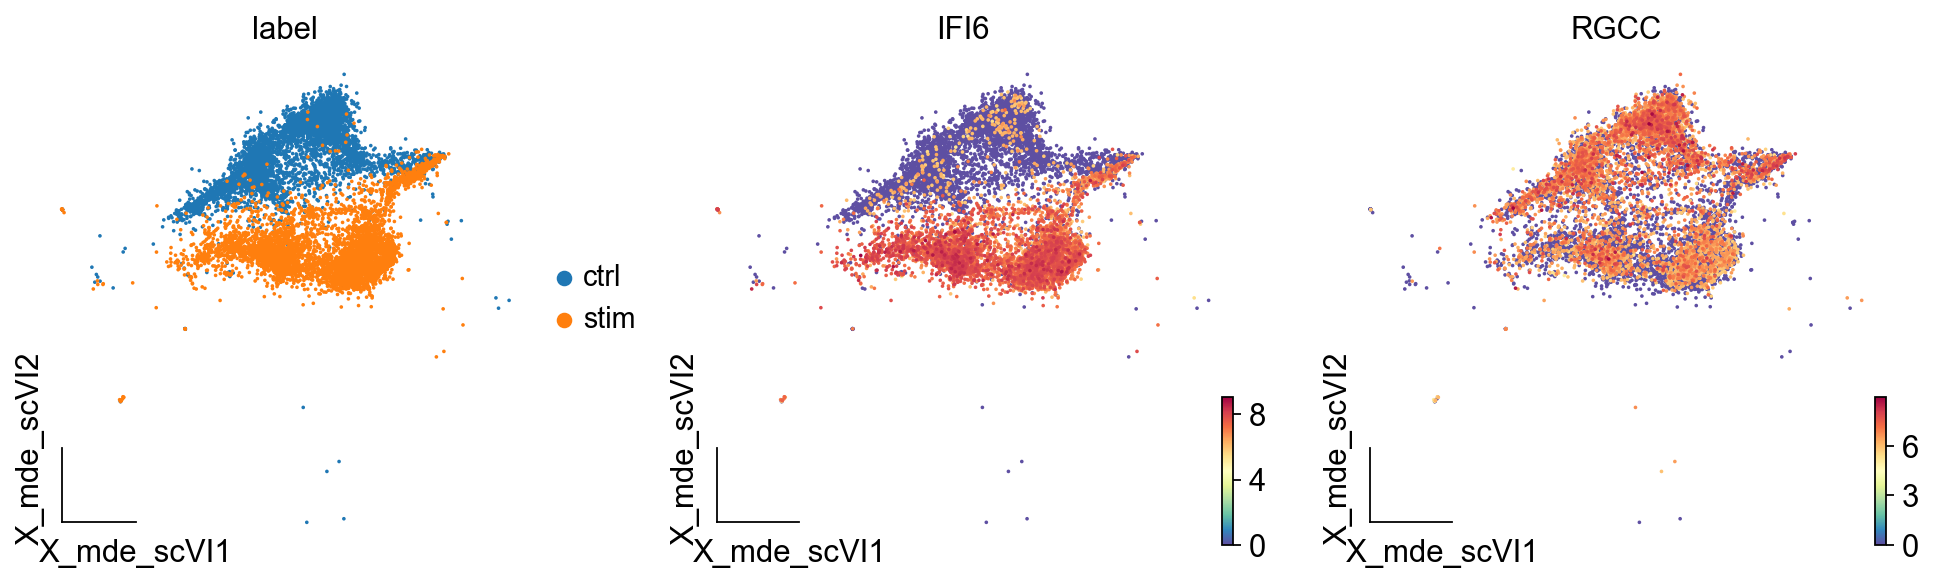

In [81]:
ov.utils.embedding(test_adata,
                   basis='X_mde_scVI',
                    frameon='small',
                   color=['label','IFI6','RGCC'])

## 5. 基于元细胞的差异表达分析

我们可以看到，无论是使用ttest与DEseq2，都可以一定程度上计算出两个组别的细胞差异表达基因，并且也确实在两个组别中实现了分离。但是，这也带来了大量的生物学噪音。两种细胞并没有实现非常完美的分离，差异表达基因的表达在两类细胞中也有着一定的丰度。

为了解决这一问题，扩大样本（细胞）的深度，我们使用SEACells聚合细胞，然后在元细胞水平上，执行差异表达分析。值得一提的是，SEACells聚合的元细胞在信号聚合和细胞分辨率之间实现了最佳平衡，并且它们捕获整个表型谱中的细胞状态，包括罕见状态。元细胞保留了样本之间微妙的生物学差异，这些差异通过替代方法作为批次效应被消除，因此，为数据集成提供了比稀疏单个细胞更好的起点。

### 5.1 元细胞初始化

在这里，我们使用`scVI`作为元细胞特征向量的初始化，你也可以使用`X_pca`或者是omicverse计算得到的`scaled|original|X_pca`来作为元细胞的初始输入。

In [ ]:
meta_obj=ov.single.MetaCell(adata,use_rep='X_scVI',n_metacells=250,
                           use_gpu=True)

我们需要初始化元细胞的原型，也就是其在特征空间scVI上的初始位置，这里可能有一些难理解，如果我们在umap图上来理解的话，可以表示为umap图上的元细胞的位置，或许会更加通俗一些。

In [39]:
meta_obj.initialize_archetypes()

Building kernel on X_scVI
Computing diffusion components from X_scVI for waypoint initialization ... 
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
Done.
Sampling waypoints ...
Done.
Selecting 239 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 21/21 [00:00<00:00, 42.44it/s]

Selecting 11 cells from greedy initialization.


### 5.2 元细胞模型训练

初始完模型结构后，我们就需要对元细胞进行聚合，在这里我们通过训练SEACells模型来完成这一目的

In [40]:
meta_obj.train(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.28753
Starting iteration 1.
Completed iteration 1.
Converged after 8 iterations.
Converged after 9 iterations.
Starting iteration 10.
Completed iteration 10.
Converged after 10 iterations.


我们提供了一个保存与读取函数，避免重复计算

In [ ]:
meta_obj.save('seacells/model.pkl')
meta_obj.load('seacells/model.pkl')

### 5.3 预测元细胞

我们可以使用 `predicted` 来预测原始 scRNA-seq 数据的元胞。有两种方法可供选择，一种是 "soft"方法，另一种是 "hard"方法。

在 "soft"方法中，汇总每个 SEACell 中的细胞，对所有原始数据求和 x 为属于一个 SEACell 的所有细胞分配权重。数据未标准化，伪原始聚合计数存储在 .layer['raw']中。与变量（.var）相关的属性会被复制过来，但每个 SEACell 的相关属性必须手动复制，因为某些属性可能需要求和或取平均值等，具体取决于属性。

在 "hard"方法中，汇总每个 SEACell 中的单元格，对属于一个 SEACell 的所有单元格的所有原始数据求和。数据未经标准化处理，原始汇总计数存储在 .layer['raw']中。与变量（.var）相关的属性会被复制过来，但每个 SEACell 的相关属性必须手动复制，因为某些属性可能需要求和或取平均值等，具体取决于属性。

我们首先需要串联细胞类型(cell_type)与组别(label)的标签用于预测。

In [42]:
meta_obj.adata.obs['celltype-label']=[i+'-'+j for i,j in zip(meta_obj.adata.obs['cell_type'],
                                                           meta_obj.adata.obs['label'])]

In [43]:
ad=meta_obj.predicted(method='soft',celltype_label='celltype-label',
                     summarize_layer='lognorm')

100%|██████████| 250/250 [01:03<00:00,  3.94it/s]


In [56]:
ad

AnnData object with n_obs × n_vars = 250 × 2000
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

<AxesSubplot: title={'center': 'Meta cells'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

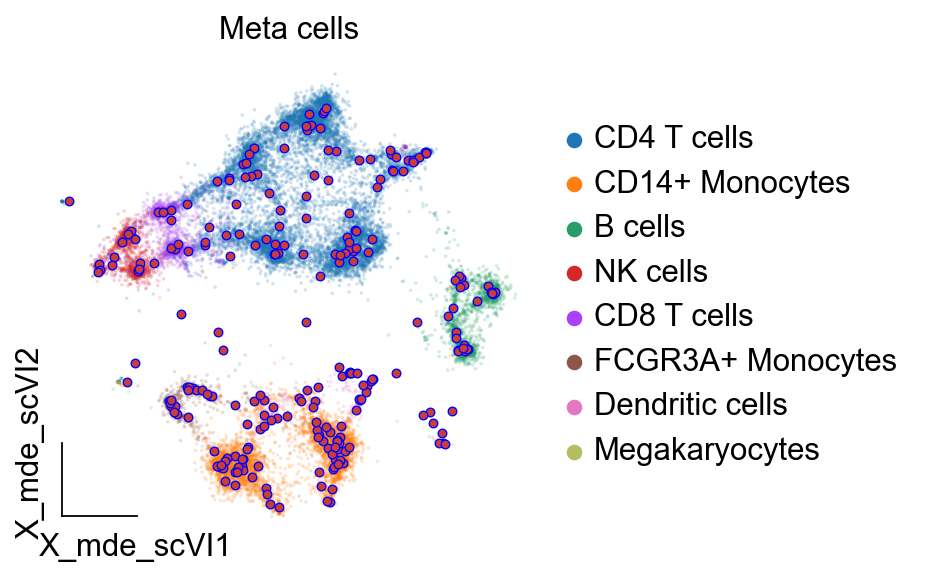

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    meta_obj.adata,
    basis="X_mde_scVI",
    color=['cell_type'],
    frameon='small',
    title="Meta cells",
    #legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    size=10,
    ax=ax,
    alpha=0.2,
    #legend_loc='', 
    add_outline=False, 
    #add_outline=True,
    outline_color='black',
    outline_width=1,
    show=False,
    #palette=ov.utils.blue_color[:],
    #legend_fontweight='normal'
)
ov.single._metacell.plot_metacells(ax,meta_obj.adata,
                                   use_rep='X_mde_scVI',color='#CB3E35',
                                  )

In [61]:
sc.pp.highly_variable_genes(ad,  n_top_genes=1500, inplace=True)
sc.tl.pca(ad, use_highly_variable=True)
sc.pp.neighbors(ad, use_rep='X_pca')
sc.tl.umap(ad)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


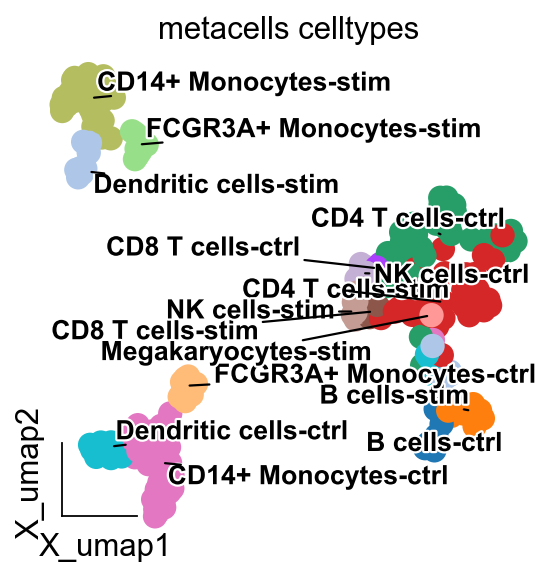

In [62]:
 import matplotlib.pyplot as plt
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    ad,
    basis="X_umap",
    color=['celltype'],
    frameon='small',
    title="metacells celltypes",
    #legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    #size=10,
    ax=ax,
    legend_loc=None, add_outline=False, 
    #add_outline=True,
    outline_color='black',
    outline_width=1,
    show=False,
    #palette=ov.palette()[12:],
    #legend_fontweight='normal'
)
ov.utils.gen_mpl_labels(
    ad,
    'celltype',
    exclude=("None",),  
    basis='X_umap',
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize= 12 ,weight='bold',
                     path_effects=[patheffects.withStroke(linewidth=2, foreground='w')] ),
)

In [70]:
test_adata=ad[ad.obs['celltype'].isin(['CD4 T cells-stim','CD4 T cells-ctrl'])]
dds_meta=ov.bulk.pyDEG(test_adata.to_df().T)
dds_meta.drop_duplicates_index()
print('... drop_duplicates_index success')

treatment_groups=test_adata.obs[test_adata.obs['celltype']=='CD4 T cells-stim'].index.tolist()
control_groups=test_adata.obs[test_adata.obs['celltype']=='CD4 T cells-ctrl'].index.tolist()
dds_meta.deg_analysis(treatment_groups,control_groups,method='ttest')

# -1 means automatically calculates
dds_meta.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=10)

... drop_duplicates_index success
... Fold change threshold: 1.4815978396550413


(<Figure size 320x320 with 1 Axes>,
 <AxesSubplot: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>)

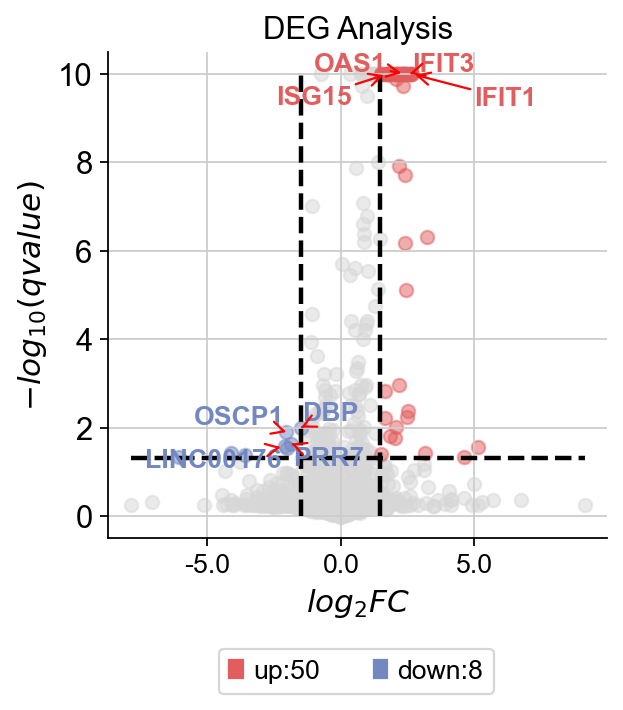

In [71]:
dds_meta.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

(<Figure size 160x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

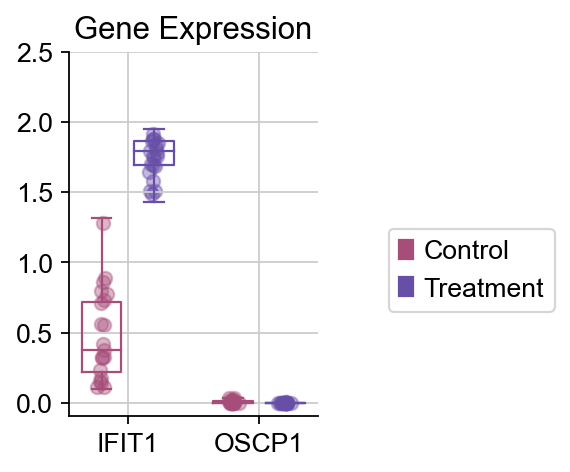

In [72]:
dds_meta.plot_boxplot(genes=['IFIT1','OSCP1'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))

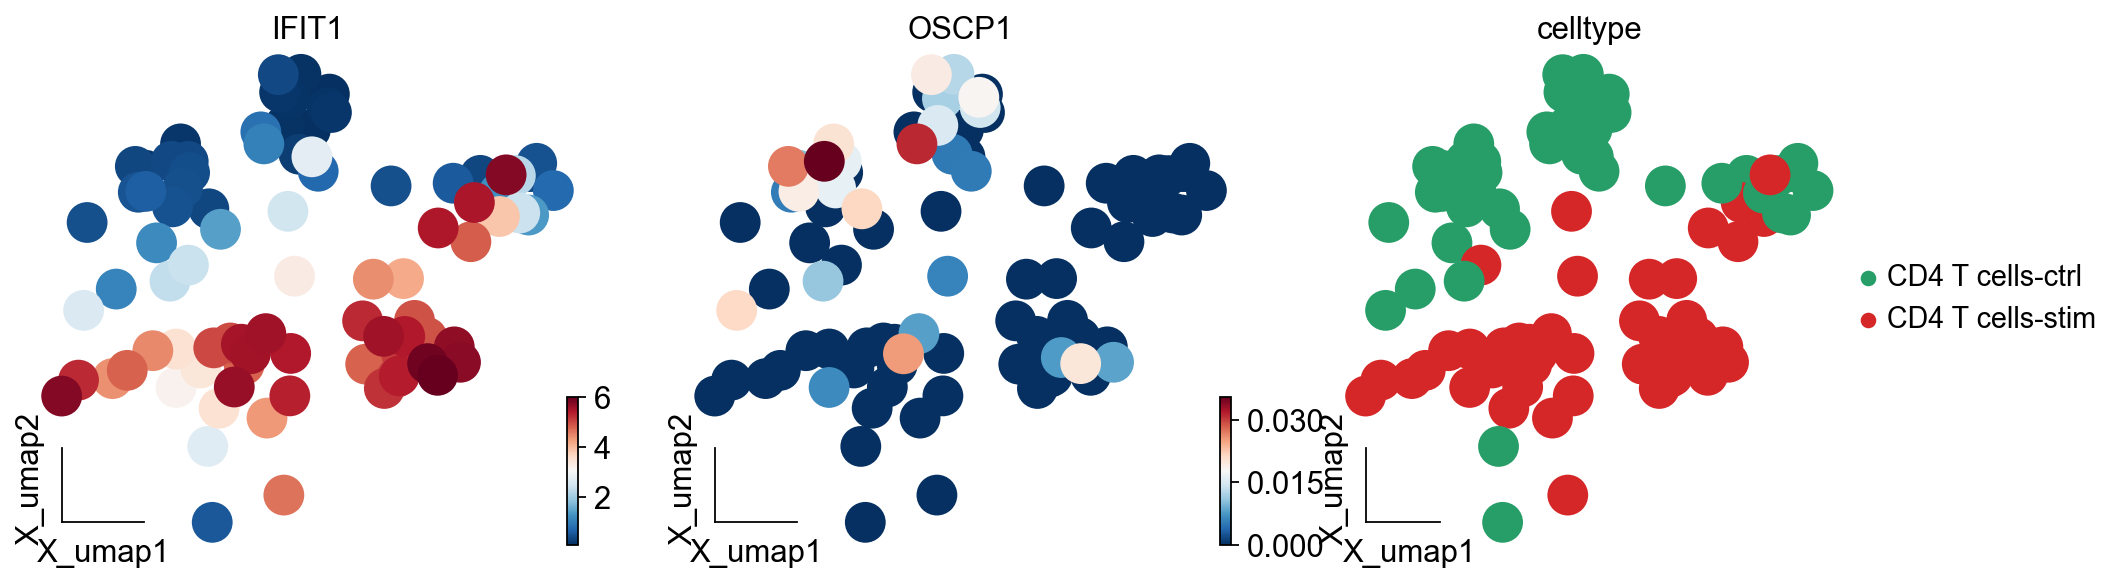

In [69]:
ov.utils.embedding(test_adata,
                   basis='X_umap',
                    frameon='small',
                   color=['IFIT1','OSCP1','celltype'],
                  cmap='RdBu_r')

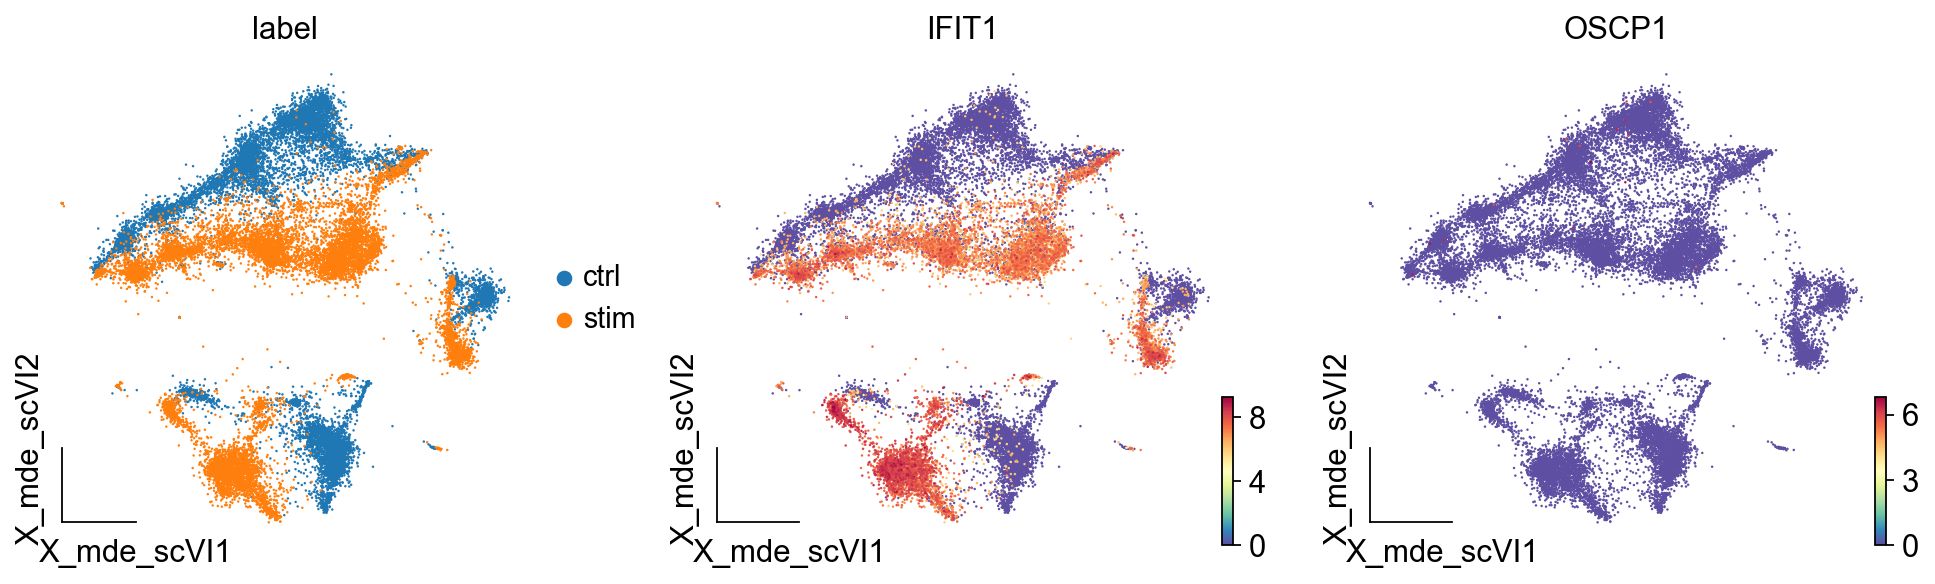

In [68]:
ov.utils.embedding(adata,
                   basis='X_mde_scVI',
                    frameon='small',
                   color=['label','IFIT1','OSCP1'])

我们发现，IFIT1和OSCP1分别在stim和ctrl组中特异性下调与上调，其中IFIT1编码一种含有四肽重复序列的蛋白质，最初被鉴定为干扰素治疗诱导的。元细胞显示出了更优的差异基因的识别优势，并且排除了dropout的干扰，我们对比箱线图可得到相同的观点。

(<Figure size 160x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

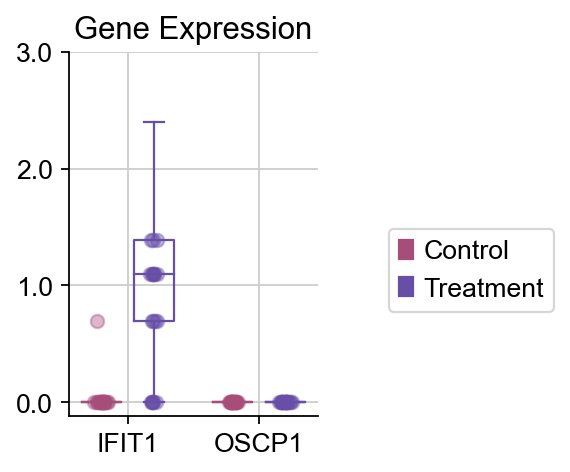

In [86]:
test_adata=adata[adata.obs['cell_type'].isin(['CD4 T cells'])]
treatment_groups=test_adata.obs[test_adata.obs['label']=='stim'].index.tolist()
control_groups=test_adata.obs[test_adata.obs['label']=='ctrl'].index.tolist()
dds.plot_boxplot(genes=['IFIT1','OSCP1'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))

## 5. 总结

我们在对单细胞数据进行差异表达分析的时候，可以从`全细胞`和`元细胞`两个角度去考虑，通常来说为了避免生物学噪音和dropout的干扰，我们会选择元细胞作为分析策略来进行。但更多时候，我们会同时使用两种方法，并进行相互印证，来表明分析的准确性与可靠性。

## 6. 思考

- 我们为什么要使用元细胞来进行差异表达分析？
- ttest与DESeq2的差异表达分析结果有什么不同？